In [30]:
# Example: Training an ECOD detector
from pyod.models.ecod import ECOD
from pyod.models.iforest import IForest
from pyod.utils.data import generate_data

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize


clf_name = 'IForest'
clf = IForest()


clf_name = 'ECOD'
clf = ECOD()


In [3]:
# Install from https://github.com/facebookresearch/segment-anything
# pip install git+https://github.com/facebookresearch/segment-anything.git

from segment_anything import SamPredictor, sam_model_registry
from tqdm.notebook import tqdm
import torch
import numpy as np

from PIL import Image
import blobfile as bf

def get_medsam_feat(images, model_weights_path = "/mnt/dataset/medsam/medsam_vit_b.pth"):

    model_type = "vit_b"
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    sam = sam_model_registry[model_type](checkpoint=model_weights_path).to(device)
    predictor = SamPredictor(sam)

    feats = []

    def load_img(path):

        with bf.BlobFile(path, "rb") as f:
            pil_image = Image.open(f)
            pil_image.load()
        pil_image = pil_image.convert("RGB")

        return np.array(pil_image)

    for img in tqdm(images):

        img = load_img(img)

        # Find a way to increase batch size
        predictor.set_image(img)

        # *** This is how you can access the patch embeddings ***
        patch_embeddings = predictor.features
        # patch_embeddings.shape gives: torch.Size([1, 256, 64, 64])

        # use maxpool?
        feat = patch_embeddings.mean(axis=1).flatten().cpu().detach().numpy()

        feats.append(feat)

    return np.array(feats)





In [4]:
import timm
import functools

params = {
    'patch_size': 14, 
    'embed_dim': 1536, 
    'depth': 40, 
    'num_heads': 24, 
    'init_values': 1e-05, 
    'mlp_ratio': 5.33334, 
    'mlp_layer': functools.partial(
        timm.layers.mlp.GluMlp, act_layer=torch.nn.modules.activation.SiLU, gate_last=False
    ), 
    'act_layer': torch.nn.modules.activation.SiLU, 
    'reg_tokens': 4, 
    'no_embed_class': True, 
    # 'img_size': 128, 
    'img_size': 224, 
    'num_classes': 0, 
    'in_chans': 3
}

model_h_optimus = timm.models.VisionTransformer(**params)

# Install from https://github.com/facebookresearch/segment-anything
from segment_anything import SamPredictor, sam_model_registry
from tqdm.notebook import tqdm
import torch
import numpy as np


import functools

import timm
import torch
from torchvision import transforms 
from torch.utils.data import Dataset
from torchvision.io import read_image

class ImageDataset(Dataset):
    def __init__(self, img_files, transform=None):
        self.img_files = img_files
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = read_image(img_path)
        # image = self.load_img(img_path)
        if self.transform:
            image = self.transform(image)
        return image

    def load_img(self, path):
        from PIL import Image
        import numpy as np
        import blobfile as bf

        with bf.BlobFile(path, "rb") as f:
            pil_image = Image.open(f)
            pil_image.load()
        pil_image = pil_image.convert("RGB")

        return np.array(pil_image)

from torch.utils.data import DataLoader


def get_h_optimus_feat(images, PATH_TO_CHECKPOINT = "/mnt/dataset/h_optimus_0/checkpoint.pth", model=None, batch_size=1):

    print("Loading model...")

    if model is None:

        params = {
            'patch_size': 14, 
            'embed_dim': 1536, 
            'depth': 40, 
            'num_heads': 24, 
            'init_values': 1e-05, 
            'mlp_ratio': 5.33334, 
            'mlp_layer': functools.partial(
                timm.layers.mlp.GluMlp, act_layer=torch.nn.modules.activation.SiLU, gate_last=False
            ), 
            'act_layer': torch.nn.modules.activation.SiLU, 
            'reg_tokens': 4, 
            'no_embed_class': True, 
            # 'img_size': 128, 
            'img_size': 224, 
            'num_classes': 0, 
            'in_chans': 3
        }

        model = timm.models.VisionTransformer(**params)

    model.load_state_dict(torch.load(PATH_TO_CHECKPOINT, map_location="cpu"))

    model.eval()
    model.to("cuda")


    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.707223, 0.578729, 0.703617), 
            std=(0.211883, 0.230117, 0.177517)
        ),
    ])

    image_dataset = ImageDataset(images, transform=transform)
    dataloader = DataLoader(image_dataset, batch_size=batch_size, shuffle=False)



    feats = []


    print("Extracting features...")

    # We recommend using mixed precision for faster inference.
    with torch.autocast(device_type="cuda", dtype=torch.float16):
        with torch.inference_mode():
            for data in tqdm(dataloader):
                # print(data.shape)
                features = model(data.to("cuda"))
                # print(features.shape)


                assert features.shape == (data.shape[0], 1536)

                feats.append(features.detach().cpu().numpy())


        # feats.append(feat)

    print(len(feats))

    return np.concatenate(feats, axis=0)





Error importing huggingface_hub.hf_api: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)
Error importing huggingface_hub.file_download: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)
Error importing huggingface_hub.file_download: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)
Error importing huggingface_hub.file_download: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)
Error importing huggingface_hub.hf_api: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)
Error importing huggingface_hub.hf_api: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)
Error importing huggingface_hub

In [5]:
import glob, os

train_dir = "/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/__ResNet50_umap_n_components_3_random_state_42_hdbscan_min_samples_10_min_cluster_size_50_v1.2/6/MoNuSegTrainingData/images/"
train_images = glob.glob(os.path.join(train_dir, "*.png"))

print(train_images)

# Compute activation from individual images
medsam_train = get_h_optimus_feat(train_images, model=model_h_optimus)



['/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/__ResNet50_umap_n_components_3_random_state_42_hdbscan_min_samples_10_min_cluster_size_50_v1.2/6/MoNuSegTrainingData/images/TCGA-G9-6362-01Z-00-DX1_025.png', '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/__ResNet50_umap_n_components_3_random_state_42_hdbscan_min_samples_10_min_cluster_size_50_v1.2/6/MoNuSegTrainingData/images/TCGA-AY-A8YK-01A-01-TS1_034.png', '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/__ResNet50_umap_n_components_3_random_state_42_hdbscan_min_samples_10_min_cluster_size_50_v1.2/6/MoNuSegTrainingData/images/TCGA-21-5784-01Z-00-DX1_045.png', '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/__ResNet50_umap_n_components_3_random_state_42_hdbscan_min_samples_10_min_cluster_size_50_v1.2/6/MoNuSegTrainingData/images/TCGA-A7-A13E-01Z-00-DX1_009.png', '/mnt/dataset/MoNuSeg/patches_valid_inst_128x128_128x128/__ResNet50_umap_n_components_3_random_state_42_hdbscan_min_samples_10_min_cluster_

  0%|          | 0/1406 [00:00<?, ?it/s]

1406


In [25]:
from sklearn.decomposition import PCA  # to apply PCA


X_train = medsam_train

pca = PCA(n_components=4)

X_train = pca.fit_transform(X_train)


In [31]:
clf.fit(X_train)


ECOD(contamination=0.1, n_jobs=1)

In [7]:
import glob, os, sys
# sys.path.append('/workspace/stardist')
# from utils.utils import *

sdm_pardir = "/mnt/dataset/MoNuSeg/out_sdm_128x128/patches_valid_128.32CH_1000st_1e-4lr_8bs_hvb_col_cos_clus6"
sdm_images = sorted(glob.glob(os.path.join(sdm_pardir, "v1.2_*/samples/*.png")))

# sdm_dirs = {os.path.split(k)[-1] : k for k in sdm_dirs}

# sdm_file_list, sdm_label = get_file_label(sdm_dirs, img_path='samples', inst_path='inst_masks')

print("sdm_file_list -> ", len(sdm_images))


sdm_file_list ->  10208


In [8]:
# Compute activation from individual images
medsam_sdm = get_h_optimus_feat(sdm_images, model=model_h_optimus)


Loading model...
Extracting features...


  0%|          | 0/10208 [00:00<?, ?it/s]

10208


In [27]:
X_test = medsam_sdm

X_test = pca.transform(X_test)

print(X_test.shape)

(10208, 4)


In [32]:
y_test_pred, y_test_pred_confidence = clf.predict(X_test, return_confidence=True)  # outlier labels (0 or 1) and confidence in the range of [0,1]


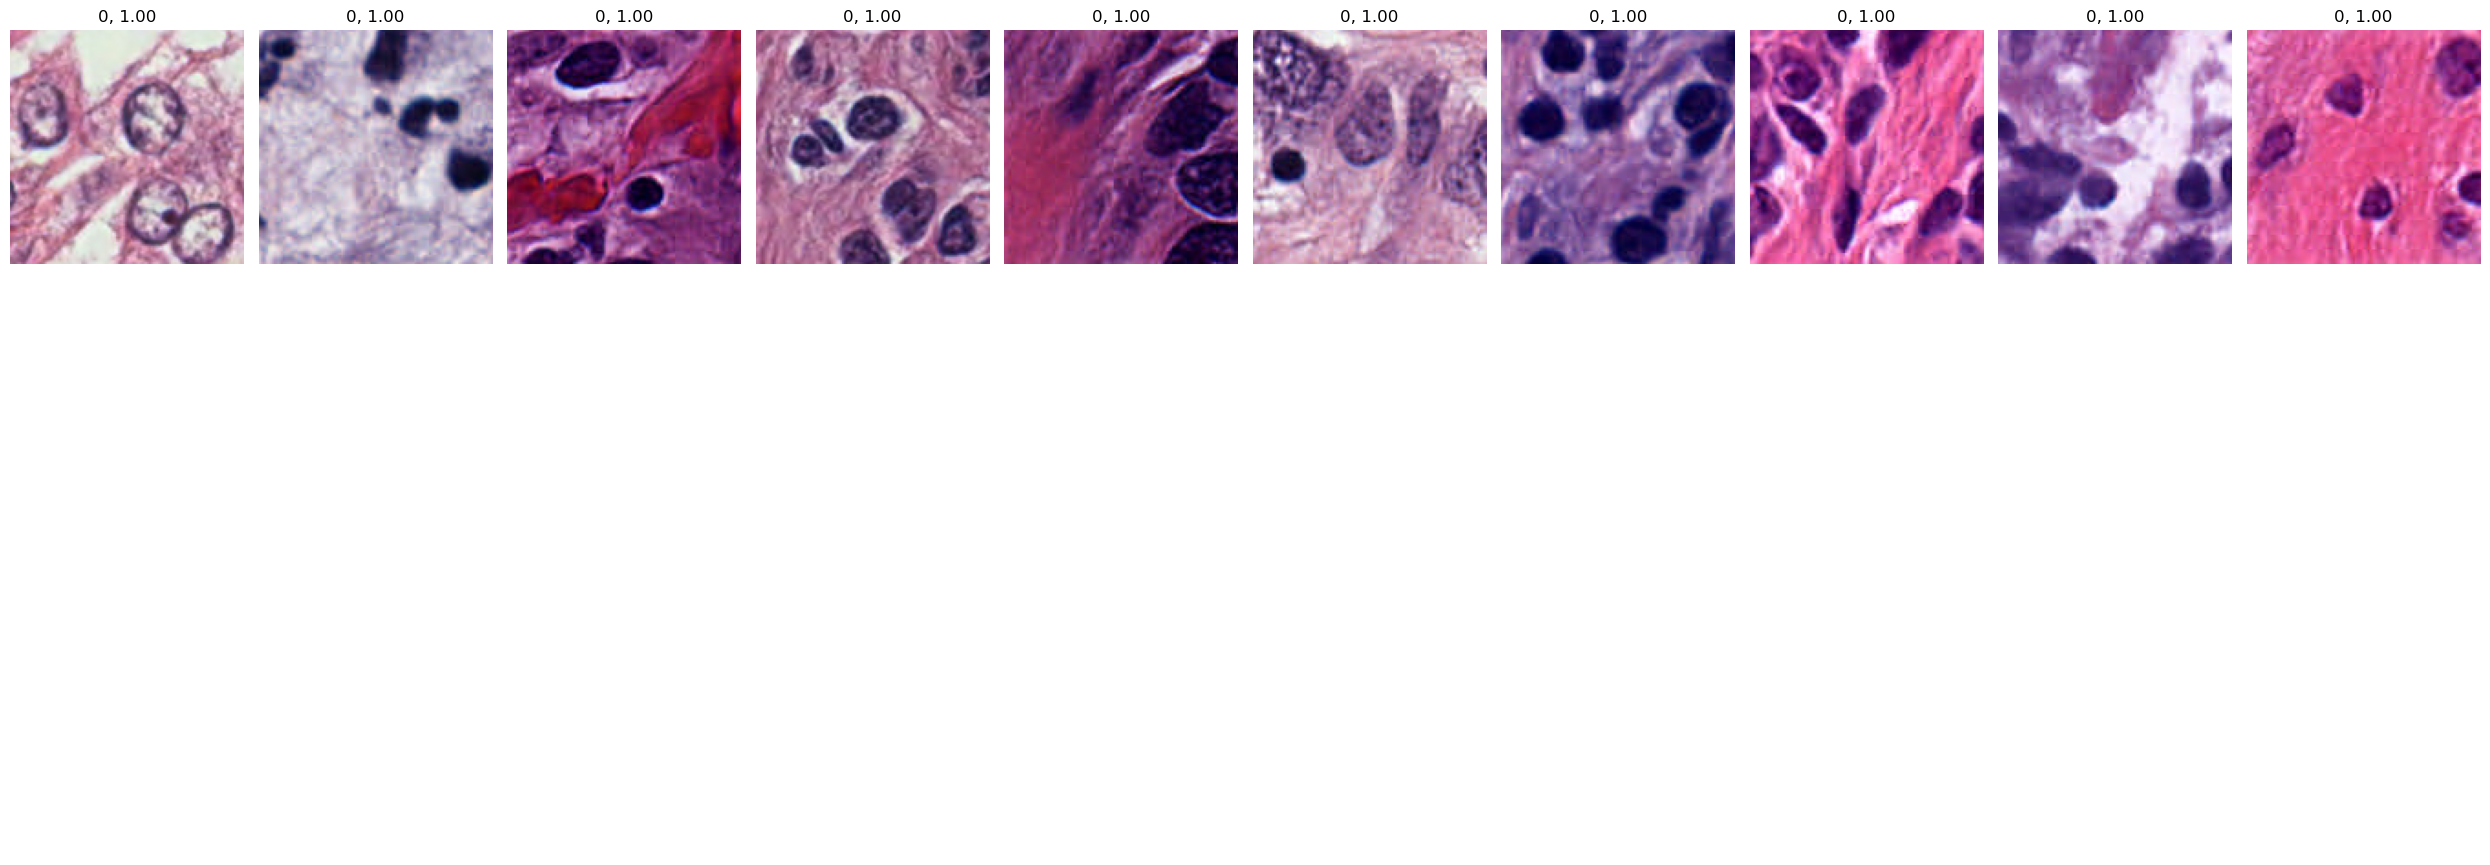

In [33]:
from matplotlib import pyplot as plt
from PIL import Image

n_img = 10
fig, ax = plt.subplots(2, n_img, figsize=(25, 10))

# np.random.seed(42)
ind = np.random.choice(len(sdm_images), n_img, replace=False)

for i in range(n_img):
    y = ind[i]
    img = Image.open(sdm_images[y])
    # img = I_smd[y]
    # ann = Y_sdm[y]
    # pred = Y_app[y]
    # app = I_app[y]
    # f1 = getattr(stats_sdm_best[y], 'f1')
    img_title = f"{y_test_pred[y]:d}, {y_test_pred_confidence[y]:.2f}"


    ax[0, i].imshow(img)
    ax[0, i].set_title(img_title)
    # ax[1, i].imshow(ann, cmap=lbl_cmap)
    # ax[2, i].set_title(df_diff['total_area'][y])
    # ax[2, i].imshow(pred, cmap=lbl_cmap)
    # ax[3, i].imshow(app)

    [axs.axis("off") for axs in ax.flatten()]

fig.tight_layout()

plt.show()